# Sheet 6: Training a RNN to learn sinusoidal oscillations

In [1]:
import torch as tc
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# TASK 2: Set the hidden size (dimension of z_t)
# Try different values: start with 2, then 4, 8, 16...
# Find the minimum number that works well
hidden_size = 4  # TODO: Replace with your choice

# Training parameters
epochs = 1000
learning_rate = 1e-4# TODO: Try different values

# TASK 4: Mini-batching parameters (uncomment and modify when needed)
# seq_length = None     # Length of sampeld subsequences for training
# batch_size = None     # Number of subsequences per batch

Data shape: torch.Size([41, 2])
Observation size: 2
Time steps: 41


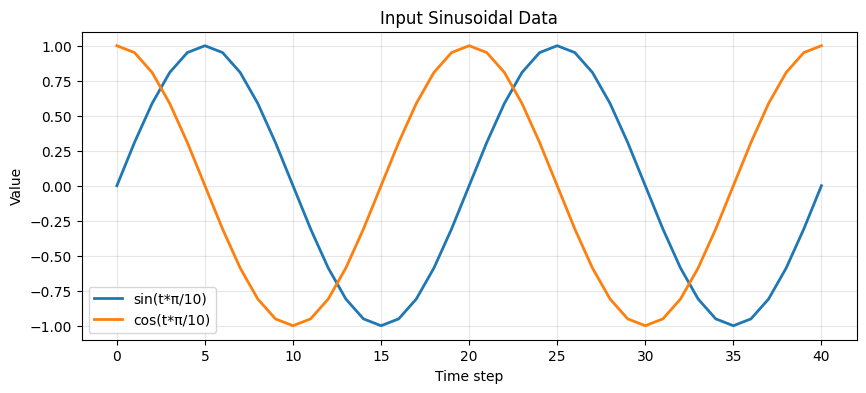

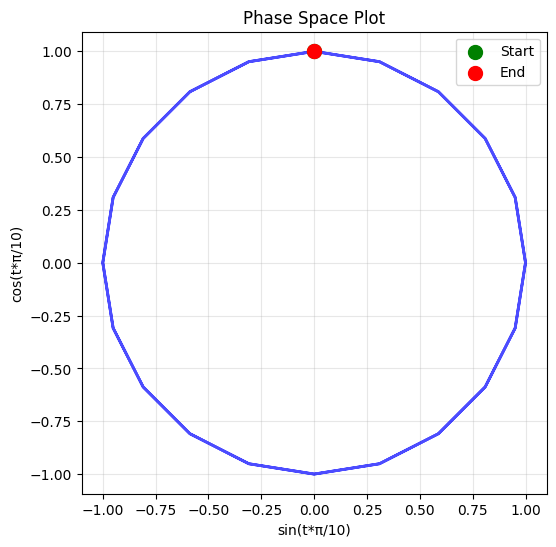

In [5]:
##%% DATA LOADING AND VISUALIZATION

# Load the sinusoidal data: x_t = [sin(t*π/10), cos(t*π/10)] for t=0,...,40
data = tc.load('sinus.pt')
observation_size = data.shape[1]  # Should be 2 (sin and cos components)

print(f"Data shape: {data.shape}")
print(f"Observation size: {observation_size}")
print(f"Time steps: {data.shape[0]}")

# Plot the input data
plt.figure(figsize=(10, 4))
plt.plot(data[:, 0], label='sin(t*π/10)', linewidth=2)
plt.plot(data[:, 1], label='cos(t*π/10)', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Input Sinusoidal Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot phase space (sin vs cos)
plt.figure(figsize=(6, 6))
plt.plot(data[:, 0], data[:, 1], 'b-', linewidth=2, alpha=0.7)
plt.scatter(data[0, 0], data[0, 1], c='green', s=100, label='Start', zorder=5)
plt.scatter(data[-1, 0], data[-1, 1], c='red', s=100, label='End', zorder=5)
plt.xlabel('sin(t*π/10)')
plt.ylabel('cos(t*π/10)')
plt.title('Phase Space Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

In [6]:
##%% MODEL DEFINITION

class LatentRNN(nn.Module):
    """
    Recurrent Neural Network for learning dynamical systems
    
    Architecture:
    z_t = tanh(C * x_{t-1} + W * z_{t-1} + h)  # Hidden state update
    \hat{x}_t = B * z_t + c                    # Output generation
    """
    
    def __init__(self, obs_dim, latent_dim):
        super(LatentRNN, self).__init__()
        
        self.obs_dim = obs_dim        # Dimension of observations (2 for sin/cos)
        self.latent_dim = latent_dim  # Dimension of hidden state z_t
       
        
        # Input-to-hidden transformation: C matrix and h bias (eq.1)
        self.C = nn.Linear(obs_dim, latent_dim)
        
        # Hidden-to-hidden transformation: W matrix (eq.1)
        self.W = nn.Linear(latent_dim, latent_dim, bias=False)
        
        # Hidden bias h (eq.1)
        self.h = nn.Parameter(tc.zeros(latent_dim))
        
        # Hidden-to-output transformation: B matrix and c bias (eq.2)
        self.B = nn.Linear(latent_dim, obs_dim)
        self.c = nn.Parameter(tc.zeros(obs_dim))
        
        
    def forward(self, time_series, h0):
        """
        Forward pass through the RNN
        
        Args:
            time_series: Input sequence of shape (seq_len, batch_size, obs_dim)
            h0: Initial hidden state of shape (1, batch_size, latent_dim)
            
        Returns:
            obs_output: Predicted observations of shape (seq_len, batch_size, obs_dim)
            h: Final hidden state of shape (1, batch_size, latent_dim)
        """
        seq_len, batch_size, _ = time_series.shape
        
        # Initialize outputs and hidden state
        obs_output = tc.zeros(seq_len, batch_size, self.obs_dim, device=time_series.device)
        h = h0.squeeze(0)  # Remove the first dimension (1, batch_size, latent_dim) -> (batch_size, latent_dim)
        
        # Process each time step
        for t in range(seq_len):
            # Get current input (t-1 in the original equations)
            x = time_series[t]
            
                    # Equation 1: h_t = tanh(Cx_{t-1} + Wh_{t-1} + b_h)
            h_next = tc.tanh(self.C(x) + self.W(h) + self.h)
            
            # Equation 2: x̂_t = Bh_t + b_x
            x_pred = self.B(h_next) + self.c
            
            # Store prediction
            obs_output[t] = x_pred
        
        # Reshape final hidden state to match input format
        h = h_next.unsqueeze(0)  # (batch_size, latent_dim) -> (1, batch_size, latent_dim)
        
        return obs_output, h
    
    

# Initialize the model
model = LatentRNN(observation_size, hidden_size)
# Print model information
print(f"\nModel Architecture:")
print(f"- Observation dimension: {observation_size}")
print(f"- Hidden dimension: {hidden_size}")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters())}")


Model Architecture:
- Observation dimension: 2
- Hidden dimension: 4
- Total parameters: 44


In [13]:
def train(model,learning_rate,hidden_size, moment=0, optimizer_function='SGD', print_loss=True, batch_size=1, batch_sequence_length=1,minibatch=False):
    """
    Training function with configurable optimizers and mini-batching
    
    Students need to implement the missing parts marked with TODO comments.
    """
    
    # TODO: Implement optimizer selection
    # Create the appropriate optimizer based on optimizer_function parameter
    # Available options: 'SGD' (with momentum support) and 'ADAM'
    # Hint: Use optim.SGD() and optim.Adam() from torch.optim
    parameters = list(model.parameters())
    
    if optimizer_function == 'SGD':
        # TODO: Initialize SGD optimizer with learning_rate and momentum
        optimizer = optim.SGD(parameters, lr=learning_rate, momentum=moment)
    elif optimizer_function == 'ADAM':
        # TODO: Initialize Adam optimizer with learning_rate
        optimizer = optim.Adam(parameters, lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_function}")
    
    # TODO: Define the loss function
    # Use Mean Squared Error (MSE) loss for this regression task
    loss_function = nn.MSELoss()
    
    losses = []
    if print_loss:
        print(f"\nStarting training for {epochs} epochs...")
        print(f"Optimizer: {optimizer_function}, LR: {learning_rate}, Batch size: {batch_size}, Sequence length: {batch_sequence_length}")
    
    for epoch in range(epochs):
        # TODO: Initialize hidden state for the batch
        # Create a tensor of shape (1, batch_size, hidden_size) with random values
        if minibatch:
            h0 = tc.rand(batch_size, hidden_size)
            h = h0
        else:
            h0 = tc.rand(1, 1, hidden_size)
            h = h0
        
        # Prepare full sequences (input and target)
        x = data[:-1]  # Input: all timesteps except the last
        y = data[1:]   # Target: all timesteps except the first
        
        # TODO: Create batch tensors for mini-batching
        # Initialize tensors to hold batch data of shape (batch_sequence_length, batch_size, observation_dim):
        X = tc.zeros(batch_sequence_length, batch_size, observation_size)
        Y = tc.zeros(batch_sequence_length, batch_size, observation_size)
        
        # TODO: Implement mini-batching
        # For each element in the batch, sample a random subsequence from the data
        # The subsequence should start at a random index and have length batch_sequence_length
        # Make sure the random index doesn't exceed the data bounds
        if minibatch:
            for j in range(batch_size):
                # TODO: Sample a random starting index for the subsequence
                # Ensure: 0 <= ind <= len(x) - batch_sequence_length
                ind = tc.randint(0, len(x) - batch_sequence_length + 1, (1,)).item()
                end_ind = ind+batch_sequence_length
                # TODO: Extract subsequence and assign to batch tensors
                X[:,j,:] = x[ind:end_ind]
                Y[:,j,:] = y[ind:end_ind]
        
        # TODO: Forward pass
        # 1. Zero the gradients from previous iteration
        # 2. Run the model forward pass with input X and initial hidden state h0
        # 3. Calculate the loss between model output and target Y
        optimizer.zero_grad()

        if minibatch:
            obs_output, h = model(X,h)
            epoch_loss = loss_function(obs_output,Y)
        else:
            obs_output, h = model(x.unsqueeze(1),h)
            epoch_loss = loss_function(obs_output.squeeze(1).squeeze(1),y)

        
        
        # TODO: Backward pass and optimization step
        # 1. Compute gradients via backpropagation
        # 2. Update model parameters
        epoch_loss.backward()

        optimizer.step()
        
        # Store loss for plotting
        losses.append(epoch_loss.item())
        
        # Print progress
        if epoch % 10 == 0 and print_loss:
            print(f"Epoch: {epoch} loss {epoch_loss.item():.6f}")
    
    return losses

In [12]:
#hidden_size = 1024
model = LatentRNN(observation_size, hidden_size)

losses = train(model,hidden_size=hidden_size,**hparams_ll)

NameError: name 'hparams_ll' is not defined

In [ ]:
##%% MODEL EVALUATION AND PREDICTION

# Generate predictions for 5 times the original sequence length
prediction_length = 5 * data.shape[0]

with tc.no_grad():
    # Initialize hidden state and predictions tensor
    # h = 
    # predictions = 
    
    # Start with first data point
    input_ = data[0:1].unsqueeze(1)  # Shape: (1, 1, obs_dim)
    
    # Generate sequence autoregressively, i.e. freely by providing the output as input
    for i in range(prediction_length):
        # TODO: make predictions and use prediction as input
        #predictions[i] =  store predictions


In [ ]:
##%% VISUALIZATION OF RESULTS